In [1]:
# kaggle notebook link https://www.kaggle.com/code/rohit1313/project1-phase-2

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # using this we can make the image of normal folder refer to normal output label and similary for pneumonia folder
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pandas as pd

2024-03-13 18:00:16.606138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 18:00:16.606244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 18:00:16.785765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [3]:
train_data_path = '../input/d/paultimothymooney/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
df

,filepaths,label
0,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
1,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
2,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
3,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
4,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
...,...,...
5211,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
5212,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
5213,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
5214,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL


In [5]:
valid_data_dir = '../input/d/paultimothymooney/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [6]:
valid

,filepaths,label
0,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
1,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
2,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
3,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
4,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
5,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
6,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
7,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
8,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
9,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL


In [7]:
test_data_dir = '../input/d/paultimothymooney/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [8]:
test

,filepaths,label
0,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
1,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
2,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
3,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
4,../input/d/paultimothymooney/chest-xray-pneumo...,PNEUMONIA
...,...,...
619,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
620,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
621,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL
622,../input/d/paultimothymooney/chest-xray-pneumo...,NORMAL


In [9]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [10]:
# crobed image size
batch_size = 16 * strategy.num_replicas_in_sync
img_size = (180,180)

tr_gen = ImageDataGenerator(rescale = 1./255)
ts_gen = ImageDataGenerator(rescale = 1./255)
val_gen= ImageDataGenerator(rescale = 1./255)

train_dataset = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

val_dataset= val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_dataset = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [11]:
# Assuming 'train_dataset' is your dataset object

# Get the shape of the data
data_shape = train_dataset.image_shape
print("Shape of data:", data_shape)


Shape of data: (180, 180, 3)


In [12]:
# Assuming the class names are 'normal' and 'pneumonia'
class_indices = train_dataset.class_indices

# Count the number of examples for each class
num_normal_examples = sum(1 for label in train_dataset.labels if label == class_indices['NORMAL'])
num_pneumonia_examples = sum(1 for label in train_dataset.labels if label == class_indices['PNEUMONIA'])

print("Number of normal examples:", num_normal_examples)
print("Number of pneumonia examples:", num_pneumonia_examples)

Number of normal examples: 1050
Number of pneumonia examples: 3122


In [13]:
train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
# train_dataset.classes

# Build the CNN

In [15]:
# # Basic model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(), # Flatten layer to convert the input tensor to 1D (input layer)
#     tf.keras.layers.Dense(64, activation=tf.nn.relu), # Hidden layer
#     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) # Output layer
# ])


In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([        
        tf.keras.layers.Flatten(input_shape=(180,180,3)),
        
        # one without dropout layer in each case or favourable case (of which validation loss converge in better way then the random graph of validation graph
        
        dense_block(32,0.5), # and 0.2
        dense_block(64,0.5),
        dense_block(64,0.5),
        dense_block(128,0.5),
        dense_block(128,0.5),
        dense_block(256,0.5),
        dense_block(256,0.5),
        dense_block(512,0.5),
        dense_block(512,0.5),
        dense_block(1024,0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


# Train the model

In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='f1_score', threshold=0.5)
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Finetune the model

In [19]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.keras",save_best_only=True)

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [20]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [21]:
weight_for_0 = (1 / num_normal_examples)*(num_normal_examples+num_pneumonia_examples)/2.0 
weight_for_1 = (1 / num_pneumonia_examples)*(num_normal_examples+num_pneumonia_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.99
Weight for class 1: 0.67


In [22]:
EPOCHS =30  #100 # 25 
history2 = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    callbacks=[checkpoint_cb, lr_scheduler],
    shuffle = False,
    verbose= 1
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/261 ━━━━━━━━━━━━━━━━━━━━ 1:48:52 25s/step - accuracy: 0.5625 - f1_score: 0.5625 - loss: 0.8545 - precision: 0.8000 - recall: 0.6154

I0000 00:00:1710352860.605566      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710352860.628509      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5204 - f1_score: 0.5204 - loss: 1.8928 - precision: 0.7605 - recall: 0.5212

W0000 00:00:1710352932.239712      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710352933.726042      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 312ms/step - accuracy: 0.5205 - f1_score: 0.5205 - loss: 1.8912 - precision: 0.7606 - recall: 0.5213 - val_accuracy: 0.6552 - val_f1_score: 0.6552 - val_loss: 0.6064 - val_precision: 0.9859 - val_recall: 0.5426 - learning_rate: 0.0100
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.6082 - f1_score: 0.6082 - loss: 0.8817 - precision: 0.8238 - recall: 0.6068 - val_accuracy: 0.7241 - val_f1_score: 0.7241 - val_loss: 0.6273 - val_precision: 0.9880 - val_recall: 0.6357 - learning_rate: 0.0089
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.6772 - f1_score: 0.6772 - loss: 0.6780 - precision: 0.8576 - recall: 0.6691 - val_accuracy: 0.8793 - val_f1_score: 0.8793 - val_loss: 0.3405 - val_precision: 0.9602 - val_recall: 0.8734 - learning_rate: 0.0079
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.7428 - f1_score: 0.7428 - loss: 0.5748 - precision: 0.8933 - recall: 0.7434 - val_accuracy: 0.8602 - val

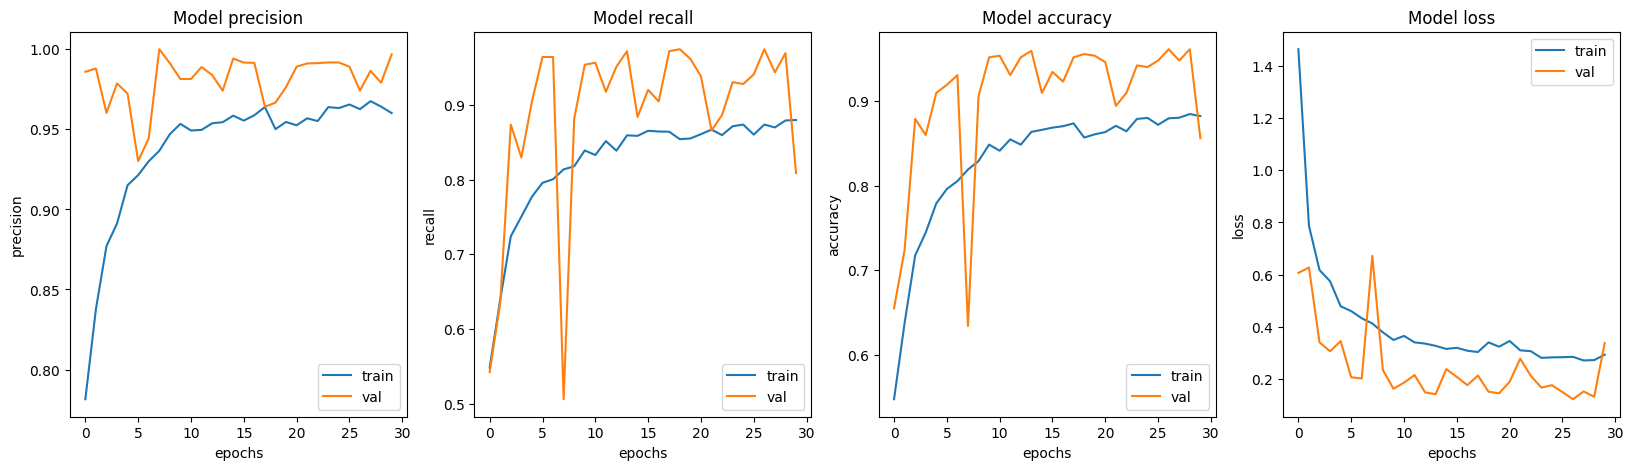

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Predict and evaluate results

In [24]:
loss, acc, prec, rec, f1 = model.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8131 - f1_score: 0.8131 - loss: 0.4028 - precision: 1.0000 - recall: 0.7377


In [25]:
# Load the model saved by ModelCheckpoint
checkpoint_model = tf.keras.models.load_model("xray_model.keras")

# Evaluate the checkpoint model
loss, acc, prec, rec, f1= checkpoint_model.evaluate(test_dataset)


 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9444 - f1_score: 0.9444 - loss: 0.1781 - precision: 0.9769 - recall: 0.9466

W0000 00:00:1710354093.520412      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9628 - f1_score: 0.9628 - loss: 0.1304 - precision: 0.9829 - recall: 0.9646
